<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/experimental/Renko_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [623]:
def make_preds(new_data, trained_model,model_name):
      '''
      new_data : df except the prediction column
      trained_model : trained model for actual prediction
      df : dataframe with the date column
      returns a df
      '''
      pred1 = pd.DataFrame(trained_model.predict(new_data))
      #ppp =df.reset_index()
      #pred1 = pd.concat([pred1 , ppp.Date],axis=1)
      #pred1= pred1.set_index('Date')
      pred1.columns = ['preds'+str(model_name)]
      return pred1

In [624]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


class renko:      
    def __init__(self):
        self.source_prices = []
        self.renko_prices = []
        self.renko_directions = []
    
    # Setting brick size. Auto mode is preferred, it uses history
    def set_brick_size(self, HLC_history = None, auto = False, brick_size = 50.0):
        if auto == True:
            self.brick_size = self.__get_optimal_brick_size(HLC_history.iloc[:, [0, 1, 2]])
        else:
            self.brick_size = brick_size
        return self.brick_size
    
    def __renko_rule(self, last_price):
        # Get the gap between two prices
        gap_div = int(float(last_price - self.renko_prices[-1]) / self.brick_size)
        is_new_brick = False
        start_brick = 0
        num_new_bars = 0

        # When we have some gap in prices
        if gap_div != 0:
            # Forward any direction (up or down)
            if (gap_div > 0 and (self.renko_directions[-1] > 0 or self.renko_directions[-1] == 0)) or (gap_div < 0 and (self.renko_directions[-1] < 0 or self.renko_directions[-1] == 0)):
                num_new_bars = gap_div
                is_new_brick = True
                start_brick = 0
            # Backward direction (up -> down or down -> up)
            elif np.abs(gap_div) >= 2: # Should be double gap at least
                num_new_bars = gap_div
                num_new_bars -= np.sign(gap_div)
                start_brick = 2
                is_new_brick = True
                self.renko_prices.append(self.renko_prices[-1] + 2 * self.brick_size * np.sign(gap_div))
                self.renko_directions.append(np.sign(gap_div))
            #else:
                #num_new_bars = 0

            if is_new_brick:
                # Add each brick
                for d in range(start_brick, np.abs(gap_div)):
                    self.renko_prices.append(self.renko_prices[-1] + self.brick_size * np.sign(gap_div))
                    self.renko_directions.append(np.sign(gap_div))
        
        return num_new_bars
                
    # Getting renko on history
    def build_history(self, prices):
        if len(prices) > 0:
            # Init by start values
            self.source_prices = prices
            self.renko_prices.append(prices.iloc[0])
            self.renko_directions.append(0)
        
            # For each price in history
            for p in self.source_prices[1:]:
                self.__renko_rule(p)
        
        return len(self.renko_prices)
    
    # Getting next renko value for last price
    def do_next(self, last_price):
        if len(self.renko_prices) == 0:
            self.source_prices.append(last_price)
            self.renko_prices.append(last_price)
            self.renko_directions.append(0)
            return 1
        else:
            self.source_prices.append(last_price)
            return self.__renko_rule(last_price)
    


    def evaluate(self, method = 'simple'):
        balance = 0
        sign_changes = 0
        price_ratio = len(self.source_prices) / len(self.renko_prices)

        if method == 'simple':
            for i in range(2, len(self.renko_directions)):
                if self.renko_directions[i] == self.renko_directions[i - 1]:
                    balance = balance + 1
                else:
                    balance = balance - 2
                    sign_changes = sign_changes + 1

            if sign_changes == 0:
                sign_changes = 1

            score = balance / sign_changes
            if score >= 0 and price_ratio >= 1:
                score = np.log(score + 1) * np.log(price_ratio)
            else:
                score = -1.0

            return {'balance': balance, 'sign_changes:': sign_changes, 
                    'price_ratio': price_ratio, 'score': score}
    
    def get_renko_prices(self):
        return self.renko_prices
    
    def get_renko_directions(self):
        return self.renko_directions
    
    def plot_renko(self, col_up = 'g', col_down = 'r'):
        fig, ax = plt.subplots(1, figsize=(20, 10))
        ax.set_title('Renko chart')
        ax.set_xlabel('Renko bars')
        ax.set_ylabel('Price')

        # Calculate the limits of axes
        ax.set_xlim(0.0, 
                    len(self.renko_prices) + 1.0)
        ax.set_ylim(np.min(self.renko_prices) - 3.0 * self.brick_size, 
                    np.max(self.renko_prices) + 3.0 * self.brick_size)
        
        # Plot each renko bar
        for i in range(1, len(self.renko_prices)):
            # Set basic params for patch rectangle
            col = col_up if self.renko_directions[i] == 1 else col_down
            x = i
            y = self.renko_prices[i] - self.brick_size if self.renko_directions[i] == 1 else self.renko_prices[i]
            height = self.brick_size
                
            # Draw bar with params
            ax.add_patch(
                patches.Rectangle(
                    (x, y),   # (x,y)
                    1.0,     # width
                    self.brick_size, # height
                    facecolor = col
                )
            )
        
        plt.show()

In [625]:
def rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['renko'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [626]:
import pandas as pd
import numpy as np


In [627]:
data_complete=pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/data_minute_2021.csv')

In [628]:
days_out=26

In [629]:
data_complete.shape

(92614, 7)

In [630]:
training_len=int(len(data_complete)*0.8)
data=data_complete[:training_len]
test_data=data_complete[training_len:]               

In [631]:
# Get optimal brick size based
optimal_brick = renko().set_brick_size(HLC_history = data[["High", "Low", "Close"]])

# Build Renko chart
renko_obj_atr = renko()
print('Set brick size to optimal: ', renko_obj_atr.set_brick_size())
renko_obj_atr.build_history(prices = data.Close)

Set brick size to optimal:  50.0


620

In [632]:
print('Renko bar prices: ', renko_obj_atr.get_renko_prices())
print('Renko bar directions: ', renko_obj_atr.get_renko_directions())
print('Renko bar evaluation: ', renko_obj_atr.evaluate())

Renko bar prices:  [14014.85, 14064.85, 14114.85, 14164.85, 14214.85, 14114.85, 14064.85, 14164.85, 14214.85, 14264.85, 14314.85, 14364.85, 14414.85, 14464.85, 14514.85, 14564.85, 14614.85, 14514.85, 14464.85, 14564.85, 14464.85, 14414.85, 14364.85, 14314.85, 14264.85, 14364.85, 14264.85, 14364.85, 14414.85, 14464.85, 14514.85, 14564.85, 14614.85, 14664.85, 14714.85, 14614.85, 14564.85, 14514.85, 14464.85, 14414.85, 14364.85, 14464.85, 14364.85, 14314.85, 14414.85, 14314.85, 14264.85, 14214.85, 14164.85, 14114.85, 14064.85, 14014.85, 13964.85, 13914.85, 13864.85, 13814.85, 13764.85, 13864.85, 13914.85, 13814.85, 13764.85, 13714.85, 13664.85, 13614.85, 13714.85, 13764.85, 13814.85, 13864.85, 13914.85, 13964.85, 14014.85, 14064.85, 14114.85, 14164.85, 14214.85, 14264.85, 14314.85, 14364.85, 14414.85, 14464.85, 14514.85, 14564.85, 14614.85, 14664.85, 14714.85, 14614.85, 14564.85, 14514.85, 14614.85, 14664.85, 14714.85, 14764.85, 14814.85, 14864.85, 14764.85, 14864.85, 14914.85, 14964.85, 

In [633]:
renko_2021=pd.DataFrame({'renko':renko_obj_atr.get_renko_prices(),'Direction':renko_obj_atr.get_renko_directions()})

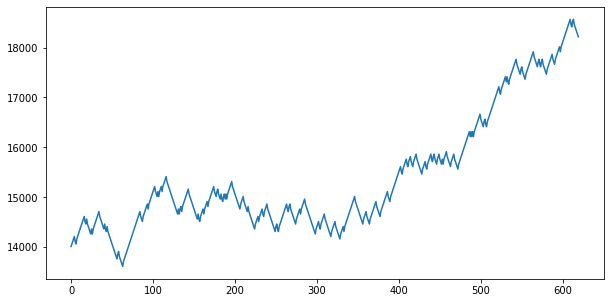

In [634]:
renko_2021.renko.plot(figsize=(10,5))

In [635]:
renko_2021['day5_pct_chg']=renko_2021.renko.pct_change(5)
renko_2021['day10_pct_chg']=renko_2021.renko.pct_change(10)
renko_2021['day15_pct_chg']=renko_2021.renko.pct_change(15)
renko_2021['day20_pct_chg']=renko_2021.renko.pct_change(20)

In [636]:
renko_2021['ema13']=renko_2021.renko.rolling(window=13).mean()

In [637]:
renko_2021['ema26']=renko_2021.renko.rolling(window=26).mean()

In [638]:
renko_2021['macd']=renko_2021['ema13']-renko_2021['ema26']

In [639]:
renko_2021['rsi']=rsi(renko_2021, periods = 14, ema = True)

In [640]:
renko_2021.tail(2)

,renko,Direction,day5_pct_chg,day10_pct_chg,day15_pct_chg,day20_pct_chg,ema13,ema26,macd,rsi
618,18264.85,-1,-0.016160,-0.013503,0.00000,0.013877,18441.773077,18266.773077,175.000000,50.959627
619,18214.85,-1,-0.013539,-0.018853,-0.00546,0.008303,18426.388462,18280.234615,146.153846,47.904210


In [641]:
train=int(len(renko_2021)*.75)
df_train= renko_2021[:train]
df_test= renko_2021[train:]

In [642]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_train['Signal_Flag'] = df_train['renko'].transform(lambda x : np.sign(x.diff(days_out)))

df_train = df_train.dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [643]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_test['Signal_Flag'] = df_test['renko'].transform(lambda x : np.sign(x.diff(days_out)))
#df_test['Signal_Flag']=np.where(df_test['Signal_Flag']==0,-1,df_test['Signal_Flag'])
df_test = df_test.dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [644]:
df_test['Signal_Flag'].value_counts()

 1.0    123
-1.0      6
Name: Signal_Flag, dtype: int64

In [645]:
X_train = df_train.drop(['Signal_Flag'],axis=1)
y_train = df_train['Signal_Flag']
X_test = df_test.drop(['Signal_Flag'],axis=1)
y_test = df_test['Signal_Flag']

In [646]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 600,max_depth=20,min_samples_leaf=4,class_weight=None,max_features='log2',min_samples_split=40, criterion = "gini", bootstrap=True,random_state = 42)
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [647]:
print('Correct Prediction RForest (%): ', f1_score(y_test, rand_frst_clf.predict(X_test), average='macro') * 100.0)

Correct Prediction RForest (%):  47.5609756097561


In [648]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100


day20_pct_chg    32.881709
rsi              21.519588
macd             21.287779
day15_pct_chg     8.196423
renko             4.896987
ema13             3.229273
day5_pct_chg      2.984827
day10_pct_chg     2.677808
ema26             1.855848
Direction         0.469758
dtype: float64

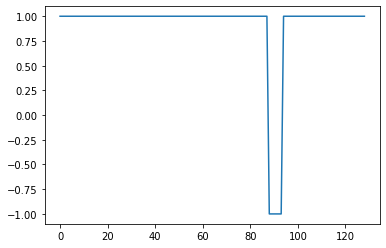

In [649]:
pd.Series(y_pred).plot()

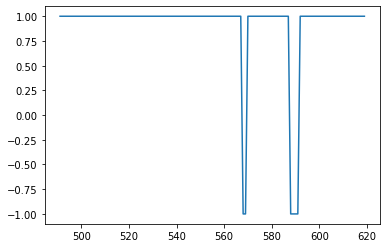

In [650]:
pd.Series(y_test).plot()

Test Module

In [651]:
# Get optimal brick size based
optimal_brick = renko().set_brick_size(HLC_history = test_data[["High", "Low", "Close"]])

# Build Renko chart
renko_obj_atr = renko()
print('Set brick size to optimal: ', renko_obj_atr.set_brick_size())
renko_obj_atr.build_history(prices = test_data.Close)

Set brick size to optimal:  50.0


245

In [652]:
renko_2021_test=pd.DataFrame({'renko':renko_obj_atr.get_renko_prices(),'Direction':renko_obj_atr.get_renko_directions()})

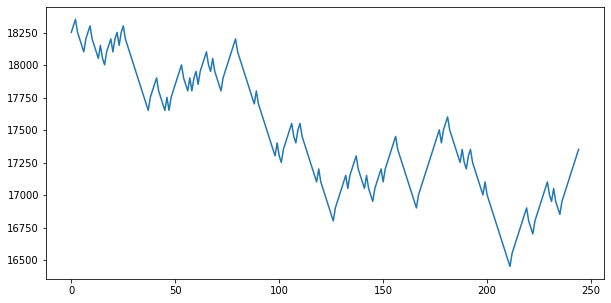

In [653]:
renko_2021_test.renko.plot(figsize=(10,5))

In [654]:
renko_2021_test['day5_pct_chg']=renko_2021_test.renko.pct_change(5)
renko_2021_test['day10_pct_chg']=renko_2021_test.renko.pct_change(10)
renko_2021_test['day15_pct_chg']=renko_2021_test.renko.pct_change(15)
renko_2021_test['day20_pct_chg']=renko_2021_test.renko.pct_change(20)

In [655]:
renko_2021_test['ema13']=renko_2021_test.renko.rolling(window=13).mean()
renko_2021_test['ema26']=renko_2021_test.renko.rolling(window=26).mean()
renko_2021_test['macd']=renko_2021_test['ema13']-renko_2021_test['ema26']

In [656]:
renko_2021_test['rsi']=rsi(renko_2021_test, periods = 14, ema = True)

In [657]:
renko_2021_test['Signal_Flag'] = renko_2021_test['renko'].transform(lambda x : np.sign(x.diff(days_out)))
#renko_2021_test['Signal_Flag']=np.where(renko_2021_test['Signal_Flag']==0,-1,renko_2021_test['Signal_Flag'])
renko_2021_test.dropna(inplace=True)

In [658]:
new_data = renko_2021_test.drop(['Signal_Flag'],axis=1)
actuals= renko_2021_test['Signal_Flag']

In [659]:
model='random_forest'

In [660]:
preds=make_preds(new_data ,rand_frst_clf,model)


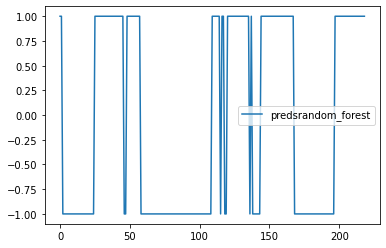

In [661]:
preds.plot()

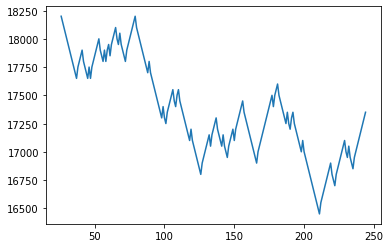

In [662]:
renko_2021_test.renko.plot()

In [663]:
#preds=np.where(preds>0,1,-1)

In [664]:
len(preds) , len(renko_2021_test)

(219, 219)

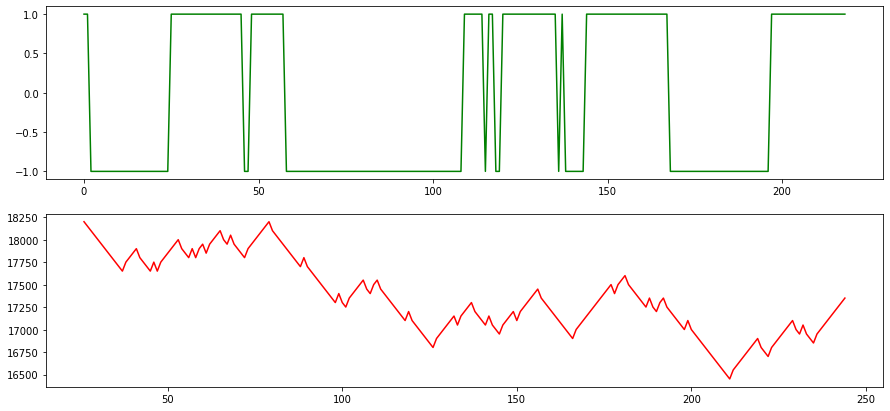

In [665]:
fig, ax = plt.subplots(2,1,figsize=(15,7))
ax[0].plot(preds,color='g')
#plt.plot(df_new['Adj Close'].values - mean, 'red', lw=1.5)
ax[1].plot(renko_2021_test.renko,color='r')


plt.show()

In [666]:
preds

,predsrandom_forest
0,1.0
1,1.0
2,-1.0
3,-1.0
4,-1.0
...,...
214,1.0
215,1.0
216,1.0
217,1.0


In [667]:
predictions=pd.concat([renko_2021_test.renko.reset_index(),preds],axis=1)

In [668]:
predictions.head(2)

,index,renko,predsrandom_forest
0,26,18201.35,1.0
1,27,18151.35,1.0


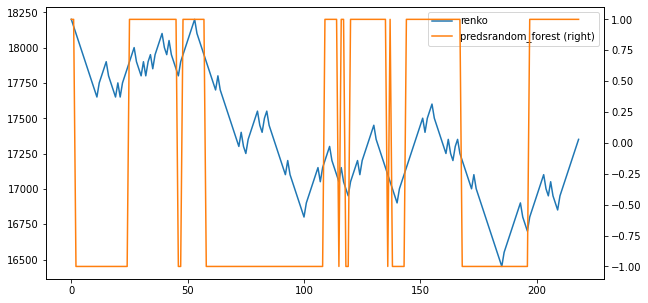

In [669]:
predictions[['renko','predsrandom_forest']].plot(figsize=(10,5),secondary_y='predsrandom_forest');

In [670]:
days_out

26